예제 8.3 DCGAN

In [ ]:
# 예제 8.3 DCGAN MNIST

# 셋업
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization, ReLU, LeakyReLU
from tensorflow.keras.layers import Dense, Reshape, Flatten, Dropout
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython import display

# 데이터셋 준비
(x_train, _), (_, _) = mnist.load_data()   # 레이블/테스트 데이터는 사용하지않음

In [ ]:
# 데이터 정규화(-1 ~ !)
x_train = (x_train.astype(np.float32) - 127.5 ) / 127.5

# 2차원 이미지를 3차원으로 변환
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)

print(x_train.shape)

(60000, 28, 28, 1)


In [ ]:
# 소규모 MNIST 데이터셋 생성
x_train = tf.data.Dataset.from_tensor_slices(x_train).batch(32)

x_train = x_train.take(200)   # 6,400개(200x32) 샘플

In [ ]:
# 생성자 정의
generator = Sequential([
    Dense(7 * 7 * 128, input_shape=(100, )),
    BatchNormalization(),
    ReLU(),
    Reshape((7, 7, 128)),

    Conv2DTranspose(64, kernel_size=4, strides=2, padding='same'),
    BatchNormalization(),
    ReLU(),

    Conv2DTranspose(32, kernel_size=4, strides=2, padding='same'),
    BatchNormalization(),
    ReLU(),

    Conv2DTranspose(1, kernel_size=4, strides=1, padding='same',
                    activation='tanh')],
    name='generator')

generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              633472    
                                                                 
 batch_normalization (Batch  (None, 6272)              25088     
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 64)        131136    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 14, 14, 64)        25

In [ ]:
# 판별자 정의
discriminator = Sequential([
    Conv2D(32, kernel_size=4, strides=2, padding='same',
           input_shape=(28, 28, 1)),
    LeakyReLU(alpha=0.2),

    Conv2D(64, kernel_size=4, strides=2, padding='same'),
    BatchNormalization(),
    LeakyReLU(alpha=0.2),

    Conv2D(128, kernel_size=4, strides=2, padding='same'),
    BatchNormalization(),
    LeakyReLU(alpha=0.2),

    Flatten(),
    Dropout(0.2),
    Dense(1, activation='sigmoid')],
    name='discriminator')

discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 32)        544       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          32832     
                                                                 
 batch_normalization_3 (Bat  (None, 7, 7, 64)          256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         131200    
                                                     

In [ ]:
# 하이퍼파라미터 설정
batch_size = 32      # 배치 크기
latent_dim = 100     # 랜덤 벡터 차원
num_generate = 100   # 생성할 이미지 수
seed = tf.random.normal([num_generate, latent_dim])   # 생성자 학습 시작 입력

# 손실 함수 설정
bce_loss = tf.keras.losses.BinaryCrossentropy()

# 옵티마이저 설정
g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
d_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

In [ ]:
# 학습 루프 함수 정의
@tf.function   # 함수를 그래프로 변환하여 속도 향상
def train_step(images):
    noise = tf.random.normal([batch_size, latent_dim])   # 랜덤 벡터

    # 판별자 학습
    with tf.GradientTape() as tape:   # 자동 미분 수행
        real_output = discriminator(images, training=True)
        fake_images = generator(noise, training=True)
        fake_output = discriminator(fake_images, training=True)

        real_loss = bce_loss(tf.ones_like(real_output), real_output)
        fake_loss = bce_loss(tf.zeros_like(fake_output), fake_output)
        d_loss = real_loss + fake_loss

    d_gradient = tape.gradient(d_loss, discriminator.trainable_variables)
    d_optimizer.apply_gradients(
        zip(d_gradient, discriminator.trainable_variables))

    # 생성자 학습
    with tf.GradientTape() as tape:   # 자동 미분 수행
        fake_images = generator(noise, training=True)
        fake_output = discriminator(fake_images, training=True)
        g_loss = bce_loss(tf.ones_like(fake_output), fake_output)

    g_gradient = tape.gradient(g_loss, generator.trainable_variables)
    g_optimizer.apply_gradients(
        zip(g_gradient, generator.trainable_variables))

In [ ]:
# 이미지 생성/저장 함수 정의
def generate_save_images(model, epoch, inputs):
    prediction = model(inputs, training=False)
    min = tf.reduce_min(prediction)
    max = tf.reduce_max(prediction)
    prediction = (prediction - min) / (max - min)  # 픽셀 값(0 ~ 1)

    fig = plt.figure(figsize=(5, 5))
    plt.subplots_adjust(wspace=0.01, hspace=0.01)

    for i in range(prediction.shape[0]):
        plt.subplot(10, 10, i + 1)
        plt.imshow(prediction[i], cmap='gray')
        plt.axis('off')

    plt.savefig(f"image at epoch {epoch}.png")

    plt.show()

In [ ]:
# 학습 함수 정의
def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)

        # 에포크마다 이미지 생성
        display.clear_output(wait=True)
        print(f"Generated Images at Epoch {epoch + 1}")
        generate_save_images(generator, epoch + 1, seed)

Generated Images at Epoch 50


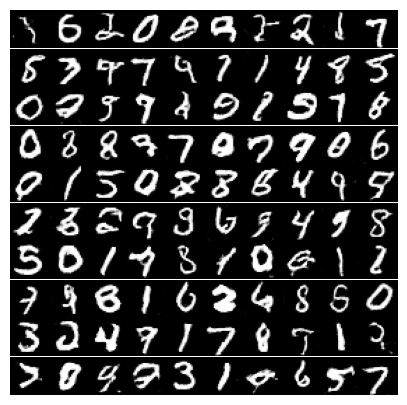

In [ ]:
# 학습(이미지 생성)
train(x_train, epochs=50)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# 모델 저장
generator.save('/content/drive/MyDrive/small_mnist_gan.h5')

In [ ]:
# 모델 불러오기
generator = tf.keras.models.load_model(
    '/content/drive/MyDrive/small_mnist_gan.h5')

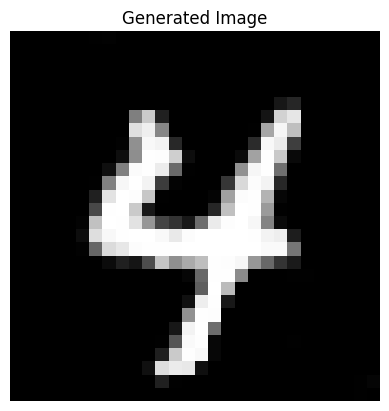

In [ ]:
# 생성 이미지 확인
tf.random.set_seed(3)

noise = tf.random.normal([1, 100])
generated_image = generator(noise)

plt.imshow(generated_image[0], cmap='gray')
plt.title('Generated Image')
plt.axis('off')

plt.show()